In [2]:
using LinearAlgebra
using SparseArrays

using Kronecker
using BenchmarkTools

using Plots
using LaTeXStrings

# Benchmark 1: FDM Implementation
The computation time of the 2D FDM implementation is benchmarked, with specific focus on the Kronecker product for the calculation of the 2D Poisson matrix. Four tests are done:
1. Dense matrices with native `kron()`
2. Sparse matrices with native `kron()`
3. Dense matrices with `kronecker()` from `Kronecker.jl`
4. Sparse matrices with `kronecker()` from  `Kronecker.jl`

Test functions are defined at the bottom of the notebook

In [28]:
N = 0;
N_ = [8, 16, 32];
t  = zeros(length(N_), 4);
for i = 1:length(N_)
    N = N_[i];
    
    bm = @benchmark test_d_main(N)
    t[i, 1] = mean(bm).time;
    
    bm = @benchmark test_s_main(N)
    t[i, 2] = mean(bm).time;
    
    bm = @benchmark test_d_kron(N)
    t[i, 3] = mean(bm).time;
    
    bm = @benchmark test_s_kron(N)
    t[i, 4] = mean(bm).time;
end

t

2×4 Matrix{Float64}:
 0.0  6.40179e7  0.0  0.0
 0.0  3.89182e8  0.0  0.0

## Results

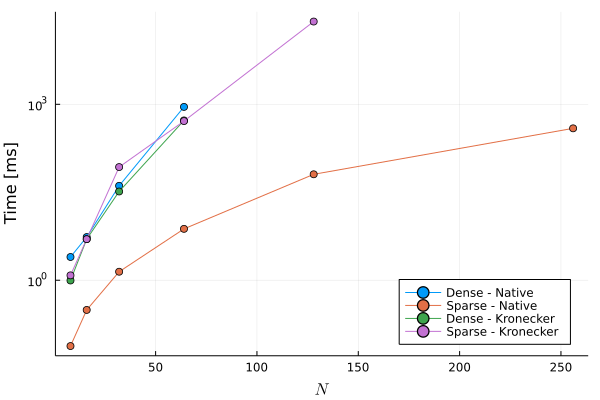

In [13]:
# Saved computation times [ns] as a function of N
N_ = [8, 16, 32, 64, 128, 256];
t = [2.48823e6 75335.1 9.89114e5 1.20933e6;
     5.44503e6 3.11225e5 5.02526e6 5.01136e6;
     4.0699e7 1.3951e6 3.25791e7 8.50252e7;
     9.02599e8  7.5118e6  5.30863e8  5.17411e8;
     NaN 6.40179e7 NaN 2.578e10;
     NaN 3.89182e8 NaN NaN];

p1 = plot(N_, t * 1e-6, yaxis = :log, shape = :circle, xlabel = L"N", ylabel = "Time [ms]", legend = :bottomright, label = ["Dense - Native" "Sparse - Native" "Dense - Kronecker" "Sparse - Kronecker"])
#savefig(p1, "kronecker_results1.png")

## Conclusion
Apparently, although the `Kronecker.jl` package promises improved performance for many matrix operations involving Kronecker products and sums, they do not improve performance in this specific application. Even worse, when combined with sparse matrices, the performance is much worse than the native implementation from `SparseArrays.jl`.

# Benchmark 2: SparseArrays
Here, the computational cost of the following items (using `SparseArrays.jl`, which was shown to be the fastest in the previous benchmark) is benchmarked:
1. Matrix construction using `kron()`
2. Solving of linear system: `u = A \ f`

## Test function

In [ ]:
# Test 5: Matrix construction & solving time using SparseArrays
function test_sa_construct(N)
    Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 
    
    e = ones(Np1);            #..same as in 1D.. 

    A1    = sparse(Tridiagonal(-e[2:end], 2*e, -e[2:end]) / h2);
    I_int = Diagonal(e); 

    A = kron(A1,I_int) + kron(I_int,A1);
    
    return A;
end

## Benchmark

In [17]:
N = 0;
N_ = [8, 16, 32, 64, 128, 256];
t  = zeros(length(N_), 2);
for i = 1:length(N_)
    N = N_[i];
    
    ## Setup
    Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

    #..construct the 2D mesh (X) starting from the 1D mesh (x)  
    #..observe that we make in the 2D mesh the x coordinate increase from left to right and 
    #..the y coordinate increase from top to bottom (as expected)
    x = Vector(0:h:1); 
    y = Vector(0:h:1); 
    X = repeat(reshape(x, 1, :), length(y), 1);
    Y = repeat(y, 1, length(x));

    #..construct the mesh indicator matrix IG 
    #..this indicator matrix will allow to distinguish interior and boundary nodes 
    #..in this indicator matrix the boundary nodes are easy to identify 
    #..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
    #..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
    IG = ones(Np1,Np1); 
    IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
    IGvec = reshape(IG,Np2,1);

    #..construct array with linear indices allowing to define interior and boundary nodes 
    #..interior: index array with all indices of the interior nodes 
    #..boundary: index array with indices of all the boundary nodes 
    L = LinearIndices(IGvec); 
    interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
    boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 
    
    sourceterm(x,y) = - 2*x*(x-1) - 2*y*(y-1); 
    #..Evaluate fsource on each node of the grid (Xh)
    #..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
    F = sourceterm.(X,Y); 
    #..Reshape the F 2D array into an f vector 
    f = reshape(F,Np2);   
    
    e = ones(Np1);            #..same as in 1D.. 
    e_bnd = ones(Nbnd); #..used to handle the boundary nodes 
    
    A1    = sparse(Tridiagonal(-e[2:end], 2*e, -e[2:end]) / h2); 
    I_int = Diagonal(e); 
    I_bnd = Diagonal(e_bnd); 
    
    A     = kron(A1,I_int) + kron(I_int,A1);
    
    # Boundary conditions
    A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
    f[boundary] = zeros(Nbnd); 
    
    ## Benchmark 1
    bm = @benchmark test_sa_construct(N);
    t[i, 1] = mean(bm).time;
    
    ## Benchmark 2
    bm = @benchmark A \ f;
    t[i, 2] = mean(bm).time;
end

t

2×2 Matrix{Float64}:
 1.14031e6  5.77267e7
 5.7269e6   2.77981e8

## Results

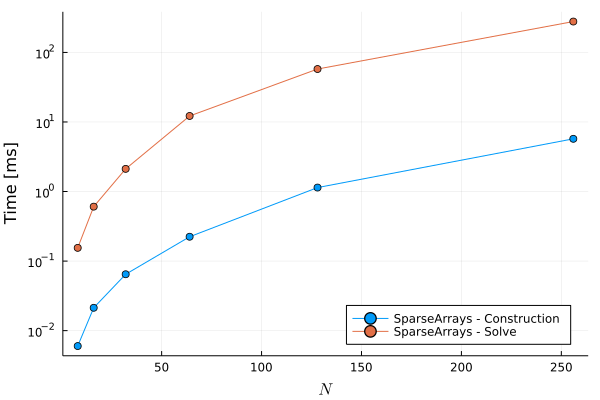

In [21]:
# Saved computation times [ns] as a function of N
N_ = [8, 16, 32, 64, 128, 256];
t = [6000.1 1.54874e5;
     21299.5 6.05974e5;
     64638.6 2.11753e6;
     2.23859e5 1.22012e7;
     1.14031e6 5.77267e7;
     5.7269e6 2.77981e8];

p2 = plot(N_, t * 1e-6, yaxis = :log, shape = :circle, xlabel = L"N", ylabel = "Time [ms]", legend = :bottomright, label = ["SparseArrays - Construction" "SparseArrays - Solve"])
#savefig(p2, "kronecker_results2.png")

# Test functions

In [16]:
# Test 1: Dense, Main.kron()
function test_d_main(N)
        Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

    #..construct the 2D mesh (X) starting from the 1D mesh (x)  
    #..observe that we make in the 2D mesh the x coordinate increase from left to right and 
    #..the y coordinate increase from top to bottom (as expected)
    x = Vector(0:h:1); 
    y = Vector(0:h:1); 
    X = repeat(reshape(x, 1, :), length(y), 1);
    Y = repeat(y, 1, length(x));

    #..construct the mesh indicator matrix IG 
    #..this indicator matrix will allow to distinguish interior and boundary nodes 
    #..in this indicator matrix the boundary nodes are easy to identify 
    #..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
    #..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
    IG = ones(Np1,Np1); 
    IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
    IGvec = reshape(IG,Np2,1);

    #..construct array with linear indices allowing to define interior and boundary nodes 
    #..interior: index array with all indices of the interior nodes 
    #..boundary: index array with indices of all the boundary nodes 
    L = LinearIndices(IGvec); 
    interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
    boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 
    
    sourceterm(x,y) = - 2*x*(x-1) - 2*y*(y-1); 
    #..Evaluate fsource on each node of the grid (Xh)
    #..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
    F = sourceterm.(X,Y); 
    #..Reshape the F 2D array into an f vector 
    f = reshape(F,Np2); 
    
    e = ones(Np1);            #..same as in 1D.. 
    e_bnd = ones(Nbnd); #..used to handle the boundary nodes 
    
    A1    = Tridiagonal(-e[2:end], 2*e, -e[2:end]) / h2; 
    I_int = Diagonal(e); 
    I_bnd = Diagonal(e_bnd); 
    
    A     = Main.kron(A1,I_int) + Main.kron(I_int,A1);

    A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
    f[boundary] = zeros(Nbnd); 
    
    u = A \ f;
    
    return u;
end

# Test 2: Sparse, Main.kron()
function test_s_main(N)
    Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

    #..construct the 2D mesh (X) starting from the 1D mesh (x)  
    #..observe that we make in the 2D mesh the x coordinate increase from left to right and 
    #..the y coordinate increase from top to bottom (as expected)
    x = Vector(0:h:1); 
    y = Vector(0:h:1); 
    X = repeat(reshape(x, 1, :), length(y), 1);
    Y = repeat(y, 1, length(x));

    #..construct the mesh indicator matrix IG 
    #..this indicator matrix will allow to distinguish interior and boundary nodes 
    #..in this indicator matrix the boundary nodes are easy to identify 
    #..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
    #..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
    IG = ones(Np1,Np1); 
    IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
    IGvec = reshape(IG,Np2,1);

    #..construct array with linear indices allowing to define interior and boundary nodes 
    #..interior: index array with all indices of the interior nodes 
    #..boundary: index array with indices of all the boundary nodes 
    L = LinearIndices(IGvec); 
    interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
    boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 
    
    sourceterm(x,y) = - 2*x*(x-1) - 2*y*(y-1); 
    #..Evaluate fsource on each node of the grid (Xh)
    #..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
    F = sourceterm.(X,Y); 
    #..Reshape the F 2D array into an f vector 
    f = reshape(F,Np2); 
    
    e = ones(Np1);            #..same as in 1D.. 
    e_bnd = ones(Nbnd); #..used to handle the boundary nodes 
    
    A1    = sparse(Tridiagonal(-e[2:end], 2*e, -e[2:end]) / h2); 
    I_int = Diagonal(e); 
    I_bnd = Diagonal(e_bnd); 
    
    A     = Main.kron(A1,I_int) + Main.kron(I_int,A1);

    A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
    f[boundary] = zeros(Nbnd); 
    
    u = A \ f;
    
    return u;
end

# Test 3: Dense, Kronecker.kronecker()
function test_d_kron(N)
    Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

    #..construct the 2D mesh (X) starting from the 1D mesh (x)  
    #..observe that we make in the 2D mesh the x coordinate increase from left to right and 
    #..the y coordinate increase from top to bottom (as expected)
    x = Vector(0:h:1); 
    y = Vector(0:h:1); 
    X = repeat(reshape(x, 1, :), length(y), 1);
    Y = repeat(y, 1, length(x));

    #..construct the mesh indicator matrix IG 
    #..this indicator matrix will allow to distinguish interior and boundary nodes 
    #..in this indicator matrix the boundary nodes are easy to identify 
    #..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
    #..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
    IG = ones(Np1,Np1); 
    IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
    IGvec = reshape(IG,Np2,1);

    #..construct array with linear indices allowing to define interior and boundary nodes 
    #..interior: index array with all indices of the interior nodes 
    #..boundary: index array with indices of all the boundary nodes 
    L = LinearIndices(IGvec); 
    interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
    boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 
    
    sourceterm(x,y) = - 2*x*(x-1) - 2*y*(y-1); 
    #..Evaluate fsource on each node of the grid (Xh)
    #..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
    F = sourceterm.(X,Y); 
    #..Reshape the F 2D array into an f vector 
    f = reshape(F,Np2); 
    
    e = ones(Np1);            #..same as in 1D.. 
    e_bnd = ones(Nbnd); #..used to handle the boundary nodes 
    
    A1    = Tridiagonal(-e[2:end], 2*e, -e[2:end]) / h2; 
    I_int = Diagonal(e); 
    I_bnd = Diagonal(e_bnd); 
    
    A     = kronecker(A1,I_int) + kronecker(I_int,A1);

    A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
    f[boundary] = zeros(Nbnd); 
    
    u = A \ f;

    return u;
end
# Test 4: Sparse, Kronecker.kronecker()
function test_s_kron(N)
    Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

    #..construct the 2D mesh (X) starting from the 1D mesh (x)  
    #..observe that we make in the 2D mesh the x coordinate increase from left to right and 
    #..the y coordinate increase from top to bottom (as expected)
    x = Vector(0:h:1); 
    y = Vector(0:h:1); 
    X = repeat(reshape(x, 1, :), length(y), 1);
    Y = repeat(y, 1, length(x));

    #..construct the mesh indicator matrix IG 
    #..this indicator matrix will allow to distinguish interior and boundary nodes 
    #..in this indicator matrix the boundary nodes are easy to identify 
    #..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
    #..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
    IG = ones(Np1,Np1); 
    IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
    IGvec = reshape(IG,Np2,1);

    #..construct array with linear indices allowing to define interior and boundary nodes 
    #..interior: index array with all indices of the interior nodes 
    #..boundary: index array with indices of all the boundary nodes 
    L = LinearIndices(IGvec); 
    interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
    boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 
    
    sourceterm(x,y) = - 2*x*(x-1) - 2*y*(y-1); 
    #..Evaluate fsource on each node of the grid (Xh)
    #..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
    F = sourceterm.(X,Y); 
    #..Reshape the F 2D array into an f vector 
    f = reshape(F,Np2); 
    
    e = ones(Np1);            #..same as in 1D.. 
    e_bnd = ones(Nbnd); #..used to handle the boundary nodes 
    
    A1    = sparse(Tridiagonal(-e[2:end], 2*e, -e[2:end]) / h2); 
    I_int = Diagonal(e); 
    I_bnd = Diagonal(e_bnd); 
    
    A     = kronecker(A1,I_int) + kronecker(I_int,A1);

    A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
    f[boundary] = zeros(Nbnd); 
    
    u = A \ f;
    
    return u;
end

test_s_kron (generic function with 1 method)